# Processing workflow example

In [1]:
from rime.process_config import *
from rime.rime_functions import *
from rime.utils import *

import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
# from dask.distributed import Client # uncomment this to open Dask client to see performance
import glob
import numpy as np
import pandas as pd
import pyam
import re
import time
import xarray as xr
import yaml




C:\Users\byers\Anaconda3\envs\py310\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


<IPython.core.display.Javascript object>

In [2]:
# Load a yaml file that will help select multiple climate indicator files (not necessarily needed)
with open('indicator_params.yml', "r") as f:
    params = yaml.full_load(f)

In [3]:
dask.config.set(scheduler="processes")
dask.config.set(num_workers=num_workers)
# client = Client()  # uncomment this to open Dask client

To see the Dask dasboard, open http://localhost:8787/status in your browser

### Import scenarios data

Load an IAMC scenarios dataset.  
Decide whether using global mean temperature or CO2 mode.  
Assign SSPs if missing and fix duplicate temperatures.  

In [4]:
df_scens_in = pyam.IamDataFrame(fname_input_scenarios)
dft = df_scens_in.filter(variable=temp_variable)

# Replace & fill missing SSP scenario allocation
dft = ssp_helper(dft, ssp_meta_col="Ssp_family", default_ssp="SSP2")

pyam.core - INFO: Reading file emissions_temp_AR6_small.xlsx
pyam.core - INFO: Found column 'exclude' in sheet 'meta', moved to attribute `IamDataFrame.exclude`.


### Build a dataset to compare SSPs and IMPs

In [5]:
scenarios = ['SSP1-26', 'SSP2-45','SSP3-Baseline','SSP5-Baseline']
variable = 'AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile'
ssps = df_scens_in.filter(scenario=scenarios, model='IMAGE*', variable=variable)
imps = df_scens_in.filter(IMP_marker=['CurPol','ModAct','SP','GS','Neg'], variable=variable) #,'Ren-2.0','Neg-2.0'
ssps_imp = ssps.append(imps)
ssps_imp = ssp_helper(ssps_imp, ssp_meta_col="Ssp_family", default_ssp="SSP2")
ssps_imp

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : COFFEE 1.1, GCAM 5.3, IMAGE 3.0, IMAGE 3.0.1, ... WITCH 5.0 (6)
 * scenario : CO_Bridge, EN_INDCi2030_3000f, ... SusDev_SDP-PkBudg1000 (9)
Timeseries data coordinates:
   region   : World (1)
   variable : ... (1)
   unit     : K (1)
   year     : 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, ... 2100 (86)
Meta indicators:
   Category (object) C3, C7, C6, C8, C1 (5)
   Category_name (object) C3: limit warming to 2°C (>67%), ... (5)
   Category_subset (object) C3x_NZGHGs, C7, C6, C8, C1a_NZGHGs (5)
   Subset_Ch4 (object) Limit to 2C (>67%) immediate 2020 action, ... (3)
   Category_Vetting_historical (object) C3, C7, C6, C8, C1 (5)
   ...

# Generate some maps

## Example 1: multiple IAM scenarios, 1 climate indicator

In [6]:
# Doesn't work -0 
# ValueError: 'threshold' is not present in all datasets.

print("Test multiple IAM scenarios, 1 indicator")
start = time.time()

ind = "precip"
var = "sdii"
short = 'sdii' #params["indicators"][ind][var]["short_name"]
ssp = "ssp2"



files = glob.glob(f"{impact_data_dir}\\{ind}\\*{short}_{ssp}*{ftype}.nc4")
mapdata = xr.open_mfdataset(
    files, preprocess=remove_ssp_from_ds, combine="nested", concat_dim="gmt"
)


map_out_MS = map_transform_gmt_multi_dask(
    ssps_imp,
    mapdata,
    years,
    use_dask=True,
    gmt_name="gmt",
    temp_min=1.2,
    temp_max=3.5,
    drawdown_max=0.15,
    interpolation=interpolation,
)

comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in map_out_MS.data_vars}
filename = f"{output_folder_maps}scenario_maps_multiscenario_{ftype}_test_notebook.nc"
map_out_MS.to_netcdf(filename, encoding=encoding)

print("FINISHED Test multiple scenarios, 1 indicator")
print(f"{time.time()-start}")

Test multiple IAM scenarios, 1 indicator
Single indicator mode
COFFEE_1_1_EN_NPi2020_400f_lowBECCS
GCAM_5_3_NGFS2_Current Policies
IMAGE_3_0_EN_INDCi2030_3000f
IMAGE_3_0_1_SSP1-26
IMAGE_3_0_1_SSP2-45
IMAGE_3_0_1_SSP3-Baseline
IMAGE_3_0_1_SSP5-Baseline
REMIND-MAgPIE_2_1-4_2_SusDev_SDP-PkBudg1000
WITCH_5_0_CO_Bridge


ValueError: 'threshold' is not present in all datasets.

In [20]:
mapdata

<xarray.Dataset>
Dimensions:     (lon: 720, lat: 360, gmt: 6)
Coordinates:
  * lon         (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat         (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    stats       object 'mean'
    gmt         (gmt) float64 1.2 1.5 2.0 2.5 3.0 3.5
    quantile    float64 0.95
Data variables:
    cdd         (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    pr_r10      (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    pr_r20      (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    pr_r95p     (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    pr_r99p     (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    sdii        (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    dri         (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    sdd_c_18p3  (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    sdd_c_24p0  (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    seas        (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    wsi         (gmt, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>

In [ ]:
map_out_MS

## Example 2: 1 scenario, multiple indicators


### Build combined dataset with multiple indicators

In [17]:
# Doesn't work -0 
# AttributeError: 'DataArray' object has no attribute 'rename_vars'
# lines 230-233 in map_transform_gmt

gmt_name="gmt"
print("Test 1 scenario, multiple indicators")
start = time.time()
ssp = "ssp2"
mapdata = xr.Dataset()
indicators = [
    "cdd",
    "precip",
    "dri",
    # "dri_qtot",
    # "ia_var",
    # "ia_var_qtot",
    "sdd_18p3",
    "sdd_24p0",
    "seas",
    "wsi",
]  #'heatwave']

for ind in indicators:
    for var in params["indicators"][ind]:
        short = params["indicators"][ind][var]["short_name"]
        print(short)
        files = glob.glob(
            os.path.join(impact_data_dir, ind, f"*{short}_{ssp}*{ftype}.nc4")
        )
        mapdata[short] = xr.open_mfdataset(
            files, preprocess=remove_ssp_from_ds, combine="nested", concat_dim="gmt"
        )[short]
mapdata = mapdata.rename({'threshold':'gmt'})
# mapdata = mapdata.isel({gmt_name:0}).reset_coords(drop=True)

Test 1 scenario, multiple indicators
cdd
pr_r10
pr_r20
pr_r95p
pr_r99p
sdii
dri
sdd_c_18p3
sdd_c_24p0
seas
wsi


C:\Users\byers\AppData\Local\Temp\ipykernel_15228\3574393669.py:33: UserWarning: rename 'threshold' to 'gmt' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  mapdata = mapdata.rename({'threshold':'gmt'})


### Run transformation (12 impact indicators) (faster with dask=False)

In [18]:
model = "AIM*"
scenario = "SSP2-34"
map_out_MI = map_transform_gmt_multi_dask(
    dft.filter(model=model, scenario=scenario),
    mapdata,
    years,
    use_dask=False,
    gmt_name=gmt_name,
)

comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in map_out_MI.data_vars}
filename = f"{output_folder_maps}scenario_maps_multiindicator_{ftype}_test_notebook.nc"
# map_out_MI.to_netcdf(filename, encoding=encoding)

print("FINISHED 1 scenario, multiple indicators")
print(f"{time.time()-start}")


TypeError: NDFrame.filter() got an unexpected keyword argument 'model'

### Data is now transformed to 10 year interval starting 2015

In [9]:
map_out_MI

NameError: name 'map_out_MI' is not defined

## Plot dashboard

In [ ]:
filename = 'test_map.html'
plot_maps_dashboard(map_out_MI, 
                    filename=filename,  year=2063, cmap='magma_r', 
                    shared_axes=True, clim=None,)
os.startfile(filename)

## Process corresponding table data, aggregated by country

### Import the climate impacts database files
Here is an example for sdii - standard precipitation index, and multiple variables, e.g.  
Exposure of land area  
Exposure of population  
Hazard value  
...  


In [31]:
filesall = glob.glob(fname_input_climate)
files = filesall#[:6]
f = files[-0]
# load input climate impacts data file
ds = xr.open_mfdataset(f)
ds = ds.sel(year=years)
ds

<xarray.Dataset>
Dimensions:                                    (gmt: 251, year: 18, ssp: 3,
                                                region: 226)
Coordinates:
  * gmt                                        (gmt) float64 1.2 1.206 ... 3.5
  * year                                       (year) int64 2015 2020 ... 2100
  * ssp                                        (ssp) object 'SSP1' 'SSP2' 'SSP3'
  * region                                     (region) object 'AFG' ... 'world'
Data variables:
    cdd|Exposure|Land area                     (gmt, year, ssp, region) float64 dask.array<chunksize=(251, 18, 3, 226), meta=np.ndarray>
    cdd|Exposure|Population                    (gmt, year, ssp, region) float64 dask.array<chunksize=(251, 18, 3, 226), meta=np.ndarray>
    cdd|Exposure|Population|%                  (gmt, year, ssp, region) float64 dask.array<chunksize=(251, 18, 3, 226), meta=np.ndarray>
    cdd|Hazard|Absolute|Land area weighted     (gmt, year, ssp, region) float64 dask.array<chunksize=(251, 18, 3, 226), meta=np.ndarray>
    cdd|Hazard|Absolute|Population weighted    (gmt, year, ssp, region) float64 dask.array<chunksize=(251, 18, 3, 226), meta=np.ndarray>
    cdd|Hazard|Risk score|Population weighted  (gmt, year, ssp, region) float64 dask.array<chunksize=(251, 18, 3, 226), meta=np.ndarray>

In [32]:
varis = list(ds.data_vars.keys())[:lvaris]
dsi = ds[varis]
print(f"# of variables = {len(varis)}")


# of variables = 6


### Select scenarios data
Load an IAMC scenarios dataset (done previously at the beginning).  
Decide whether using global mean temperature or CO2 mode.  
Assign SSPs if missing and fix duplicate temperatures. 

In [33]:
mode = 'GMT'
if mode == "GMT":
    dfp = df_scens_in.filter(variable=temp_variable)
elif mode == "bypass":
    dfp = prepare_cumCO2(df_scens_in, years=years, use_dask=True)
    ts = dfp.timeseries().apply(co2togmt_simple)
    ts = pyam.IamDataFrame(ts)
    ts.rename(
        {
            "variable": {ts.variable[0]: "RIME|GSAT_tcre"},
            "unit": {ts.unit[0]: "°C"},
        },
        inplace=True,
    )
    # Export data to check error and relationships
    # ts.append(dfp).to_csv('c://users//byers//downloads//tcre_gmt_output.csv')
    dfp = ts
    dfp.meta = df_scens_in.meta.copy()
dfp = dfp.filter(year=years)

In [34]:
# For testing on C1 scenarios
# few_scenarios = True
# very_few_scenarios = False

# if few_scenarios:
#     dfp = dfp.filter(Category=["C1*"])
#     if very_few_scenarios:
#         dfp = dfp.filter(model="REMIND 2.1*", scenario="*") 
        
dfp = ssps_imp


In [35]:
# pre-prepare the dataset into correct format
#  Assign SSP to meta and select SSP2 in case SSP not present in name
dfp = ssp_helper(dfp, ssp_meta_col="Ssp_family", default_ssp="SSP2", keep_meta=False)

dft = dfp.timeseries()
dft = dft.join(dfp.meta['Ssp_family']).reset_index()
# dft = dft.apply(fix_duplicate_temps, years=years, axis=1)

### START PROCESSING 

In [36]:
start = time.time()
year_res = 10
parallel = True
if parallel:
    """
    For parallel processing, convert dft as a wide IAMC pd.Dataframe
    into a dask.DataFrame.
    """
    ddf = dd.from_pandas(dft, npartitions=1000)

    # dfx = dft.iloc[0].squeeze()  # FOR DEBUIGGING THE FUNCTION
    outd = ddf.apply(
        calculate_impacts_gmt, dsi=dsi, ssp_meta_col="Ssp_family", axis=1, meta=("result", None)
    )

    with ProgressBar():
        # try:
        df_new = outd.compute(num_workers=num_workers)
else:
    df_new = dft.apply(calculate_impacts_gmt, dsi=dsi, axis=1)

expandeddGMT = pd.concat([df_new[x] for x in df_new.index])
print(f" Done:  {time.time()-start}")

filename = f"RIME_output_{region}_{year_res}yr.csv"

# expandedd.to_csv(filename, encoding="utf-8", index=False)
print(f" Saved: {region} yrs={year_res}\n  {time.time()-start}")
print(f"{len(dsi.data_vars)} variables, {len(dfp.meta)} scenarios")

[                                        ] | 0% Completed | 114.62 ms

C:\Users\byers\AppData\Roaming\Python\Python310\site-packages\dask\dataframe\utils.py:312: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([], dtype=dtype, name=name, index=index)


[########################################] | 100% Completed | 21.77 s
 Done:  22.688447952270508
 Saved: COUNTRIES yrs=10
  22.688447952270508
6 variables, 9 scenarios


To see the Dask dasboard, open http://localhost:8787/status in your browser

In [37]:
expandeddGMT = pyam.IamDataFrame(expandeddGMT)

In [38]:
expandeddGMT.variable

['RIME|cdd|Exposure|Land area',
 'RIME|cdd|Exposure|Population',
 'RIME|cdd|Exposure|Population|%',
 'RIME|cdd|Hazard|Absolute|Land area weighted',
 'RIME|cdd|Hazard|Absolute|Population weighted',
 'RIME|cdd|Hazard|Risk score|Population weighted']

<Axes: title={'center': 'region: GBR - variable: RIME|cdd|Exposure|Population|%'}, xlabel='Year', ylabel='%'>

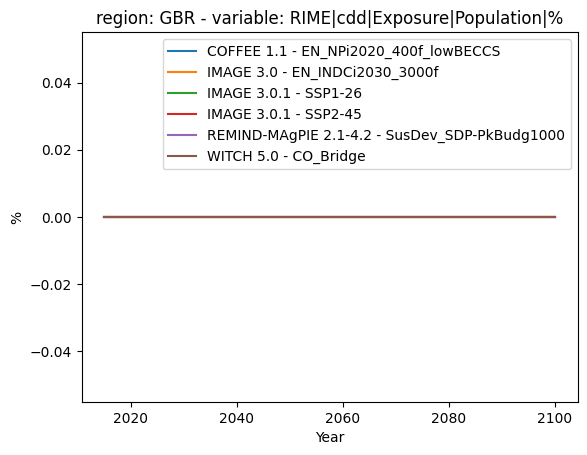

In [45]:
# model = "IMAG*"
scenario = ['CO_Bridge',
 'EN_INDCi2030_3000f',
 'EN_NPi2020_400f_lowBECCS',
 # 'NGFS2_Current Policies',
 'SSP1-26',
 'SSP2-45',
 # 'SSP3-Baseline',
 # 'SSP5-Baseline',
 'SusDev_SDP-PkBudg1000']
variable = 'RIME|sdii|Hazard|Risk score|Population weighted'
# variable = 'RIME|wsi|Exposure|Population|%'
variable = 'RIME|cdd|Exposure|Population|%'
expandeddGMT.filter(variable=variable,
                   scenario=scenario, region='GBR').plot()

pyam.core - WARNING: Filtered IamDataFrame is empty!


<Axes: xlabel='Year', ylabel='Value'>

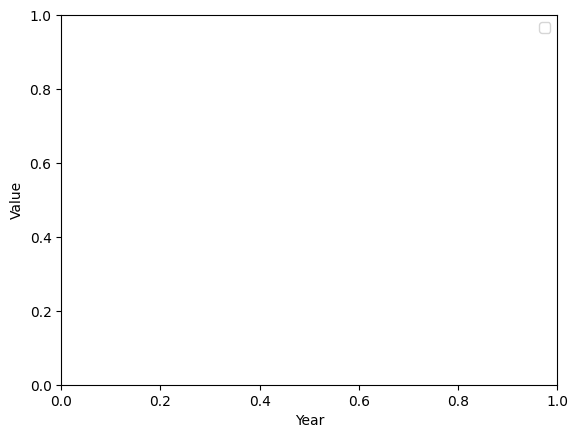

In [40]:
expandeddGMT.filter(variable= variable,
                   scenario=scenario, region='PAK').plot()

In [41]:
expandeddGMT.variable

['RIME|cdd|Exposure|Land area',
 'RIME|cdd|Exposure|Population',
 'RIME|cdd|Exposure|Population|%',
 'RIME|cdd|Hazard|Absolute|Land area weighted',
 'RIME|cdd|Hazard|Absolute|Population weighted',
 'RIME|cdd|Hazard|Risk score|Population weighted']

### Make SSP & IMP plots for presentation

In [42]:
imps.scenario

['EN_NPi2020_400f_lowBECCS',
 'NGFS2_Current Policies',
 'EN_INDCi2030_3000f',
 'SusDev_SDP-PkBudg1000',
 'CO_Bridge']

<Axes: xlabel='Year', ylabel='K'>

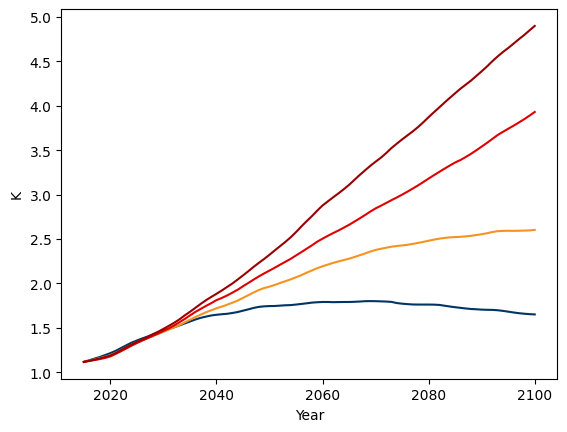

In [25]:
color_map = {
    'SSP1-26': 'AR6-SSP1-2.6',
    'SSP2-45': 'AR6-SSP2-4.5',
    'SSP3-Baseline': 'AR6-SSP3-7.0',
    'SSP5-Baseline': 'AR6-SSP5-8.5',
    'NGFS2_Current Policies': 'AR6-IP-CurPol',
    # 'EN_NPi2020_900f': 'AR6-IMP-Neg2.0',
    'EN_INDCi2030_3000f': 'AR6-IP-ModAct',
    # 'SSP2_openres_lc_50': 'AR6-IMP-Ren2.0',
    # AR6-IMP-GS',
    'CO_Bridge': 'AR6-IMP-GS',
    'EN_NPi2020_400f_lowBECCS': 'AR6-IMP-Neg',
    'SusDev_SDP-PkBudg1000': 'AR6-IMP-SP',
}

pyam.run_control().update({'color': {'scenario': color_map}})

ssps_imp.filter(variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile',
               scenario='SSP*').plot(
    legend=False, fill_between=True, color='scenario', title='')




In [ ]:
ssps_imp.filter(variable='AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile').plot(
    legend=False, fill_between=True, color='scenario', title='')